In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import operator
import pickle
import random
from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw

from demo import (extract_all, load_retrieved_candidates,
                  load_sub_seq2seq_output, merge,
                  merge_predicted_frag_with_substructures,
                  prepaire_sub_seq2seq_input, rerank_candidates,
                  save_input_for_dual_encoder, save_input_for_subseq2seq,
                  view_sub_extractions)
from utils.smiles_utils import smi_tokenizer


In [3]:
# this file is a dictionary, key: target (reactants), value: source (all possible products)
# it is generated on the train and val data by 'data_utils/collect_reaction.py', and is used
# to filter substructures extracted from candidate reactants (target side) but not exists in
# the product molecules (source side). It means that the substructures shall also remain
# unchanged during the reaction from source (product of retrieved candidate reactants) to 
# target (retrieved candidate reactants). 
# load only for the first time
try:
    all_reaction_t2s
except NameError:
    all_reaction_t2s = pickle.load(open('demo_data/reaction.pkl', 'rb'))

input_product_smiles: O=C(C=Cc1ccc2c(c1)OCO2)c1ccc2c(c1)OCO2
golden_reactants_smiles: CC(=O)c1ccc2c(c1)OCO2.O=Cc1ccc2c(c1)OCO2


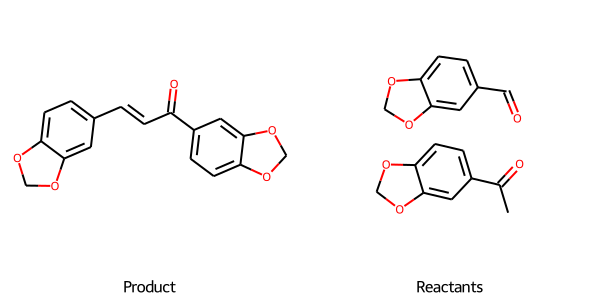

In [4]:

# we prepaire 200 samples in demo_data/test_cases.json, in which 's' is the source (product) and 't' is the target (reactant)
test_cases = json.load(open('demo_data/test_cases.json'))
# some typical cases in test_cases.json, change the value of test_case_idx below to view results
#   1 Suzuki-Miyaura Cross Coupling
#   2 Amide Condensation
#   5 SN2 Substitution
#   6 Ester Hydrolysis(Deprotection)
#  16 Sonogashira Cross Coupling
#  19 Nitro Reduction
#  22 Free Radical Halogenation
#  43 Nitrile Hydrolysis
#  56 Aldol Condensation
# 145 Sulphur Oxidation

# please change test_case_idx, or change the input below, to try other examples
test_case_idx = 56

input_product_smiles, golden_reactants_smiles = test_cases[test_case_idx]['s'], test_cases[test_case_idx]['t']
print(f'input_product_smiles: {input_product_smiles}')
print(f'golden_reactants_smiles: {golden_reactants_smiles}')
Draw.MolsToGridImage([Chem.MolFromSmiles(input_product_smiles), Chem.MolFromSmiles(golden_reactants_smiles)], \
    legends=['Product', 'Reactants'],
    molsPerRow=2, subImgSize=(300, 300))

In [5]:
# the input of the dual encoder is tokenized SMILES of product
tokenized_product_smi = smi_tokenizer(input_product_smiles)
# save the input to file
save_input_for_dual_encoder(tokenized_product_smi)
print('tokenized_product_smi: ', tokenized_product_smi)

tokenized_product_smi:  O = C ( C = C c 1 c c c 2 c ( c 1 ) O C O 2 ) c 1 c c c 2 c ( c 1 ) O C O 2


In [6]:
# view the script to retrieve reactions top 20 candidates
# the input file is 'test_input_dual_encoder.txt'
# the output file is 'test_input_dual_encoder.top20.txt'
! cat demo_data/retrieval_script.sh

#!/bin/bash

# current directory
CURRENT_DIR=$PWD
# script directory
SCRIPT_DIR=$(cd "$(dirname "${BASH_SOURCE[0]}")" &> /dev/null && pwd)
# change to script directory
cd $SCRIPT_DIR
# retrieve top 20 candidates
top=20
# run the retrieval script
python3 -u ../RetrievalModel/search_index.py \
        --input_file test_input_dual_encoder.txt \
        --output_file test_input_dual_encoder.top${top}.txt \
        --ckpt_path retrieval/query_encoder \
        --args_path retrieval/args \
        --vocab_path retrieval/src.vocab \
        --index_file candidates.txt \
        --index_path retrieval/mips_index \
        --topk ${top} \
        --allow_hit \
        --batch_size 1024
# change back to current directory
cd $CURRENT_DIR

In [7]:
# run script to retrieve candidates
! conda run -n retrieval bash demo_data/retrieval_script.sh 

09/13/2022 02:31:02 - INFO - __main__ - Loading model...
09/13/2022 02:31:04 - INFO - __main__ - Collecting data...
09/13/2022 02:31:05 - INFO - __main__ - Collected 1 instances
09/13/2022 02:31:05 - INFO - __main__ - Start search
09/13/2022 02:31:05 - INFO - __main__ - finished 1 / 1



In [8]:
# view output of dual encoder (all content in 1 line)
# tokenized_product_SMILES \TAB TGT_PLACEHOLDER \TAB retrieved_candidate_SMILES_1 \SPACE score_1 \SPACE retrieved_candidate_SMILES_2 \SPACE score_2	...
# \TAB => \t , \SPACE=> space, TGT_PLACEHOLDER is a placeholder which is not used
! cat demo_data/test_input_dual_encoder.top20.txt

O = C ( C = C c 1 c c c 2 c ( c 1 ) O C O 2 ) c 1 c c c 2 c ( c 1 ) O C O 2	TGT_PLACEHOLDER	C C ( = O ) C C ( C ) = O . C C C C N . C C C C O B ( O C C C C ) O C C C C . C C O C ( C ) = O . O = C c 1 c c c 2 c ( c 1 ) O C C O 2	0.941260814666748	O = C ( C ( = O ) c 1 c c c 2 c ( c 1 ) O C O 2 ) c 1 c c c 2 c ( c 1 ) O C O 2	0.9398974180221558	C C ( C = O ) C c 1 c c c 2 c ( c 1 ) O C O 2 . c 1 c c c 2 c ( c 1 ) O C O 2	0.9398137927055359	C C ( = O ) C C c 1 c c c 2 c ( c 1 ) O C O 2 . c 1 c c c ( C C [P+] ( c 2 c c c c c 2 ) ( c 2 c c c c c 2 ) c 2 c c c c c 2 ) c c 1	0.9396054744720459	C C ( = O ) O C = C ( C ) C c 1 c c c 2 c ( c 1 ) O C O 2 . C C ( C = O ) C c 1 c c c 2 c ( c 1 ) O C O 2	0.9394044280052185	C C C ( Br ) ( Br ) C C . O = C ( C = C c 1 c c c 2 c ( c 1 ) O C O 2 ) c 1 c c c c ( O ) c 1 . [Br-]	0.9384398460388184	C C ( Br ) C ( C ) Br . O = C ( C = C c 1 c c c 2 c ( c 1 ) O C O 2 ) c 1 c c c c ( O ) c 1 . [Br-]	0.9383258819580078	C C ( = O ) c 1 c c c c ( O ) c 1 . O = C

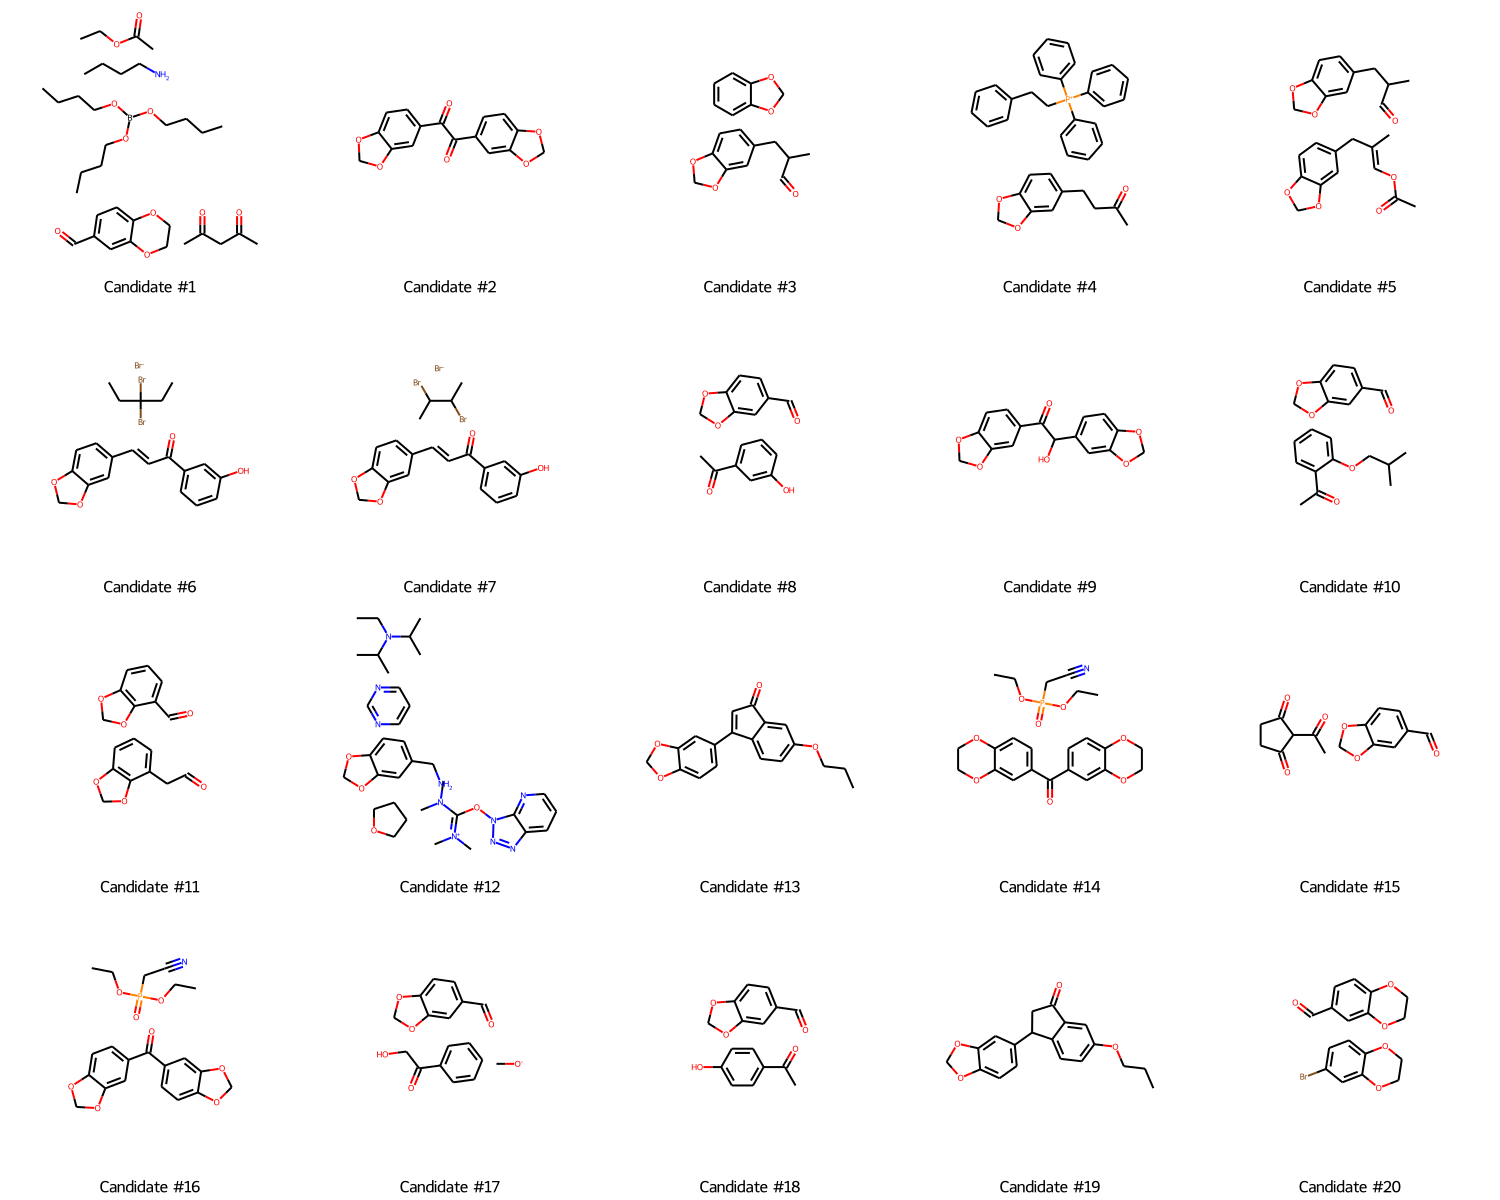

In [9]:
# the total number of candidates might be 19, as we remove the input_product_smiles from retrieved candidates if exists
candidates = load_retrieved_candidates(input_product_smiles)
Draw.MolsToGridImage([Chem.MolFromSmiles(cand) for cand in candidates], molsPerRow=5, subImgSize=(300, 300), legends= [f'Candidate #{i+1}' for i in range(len(candidates))])

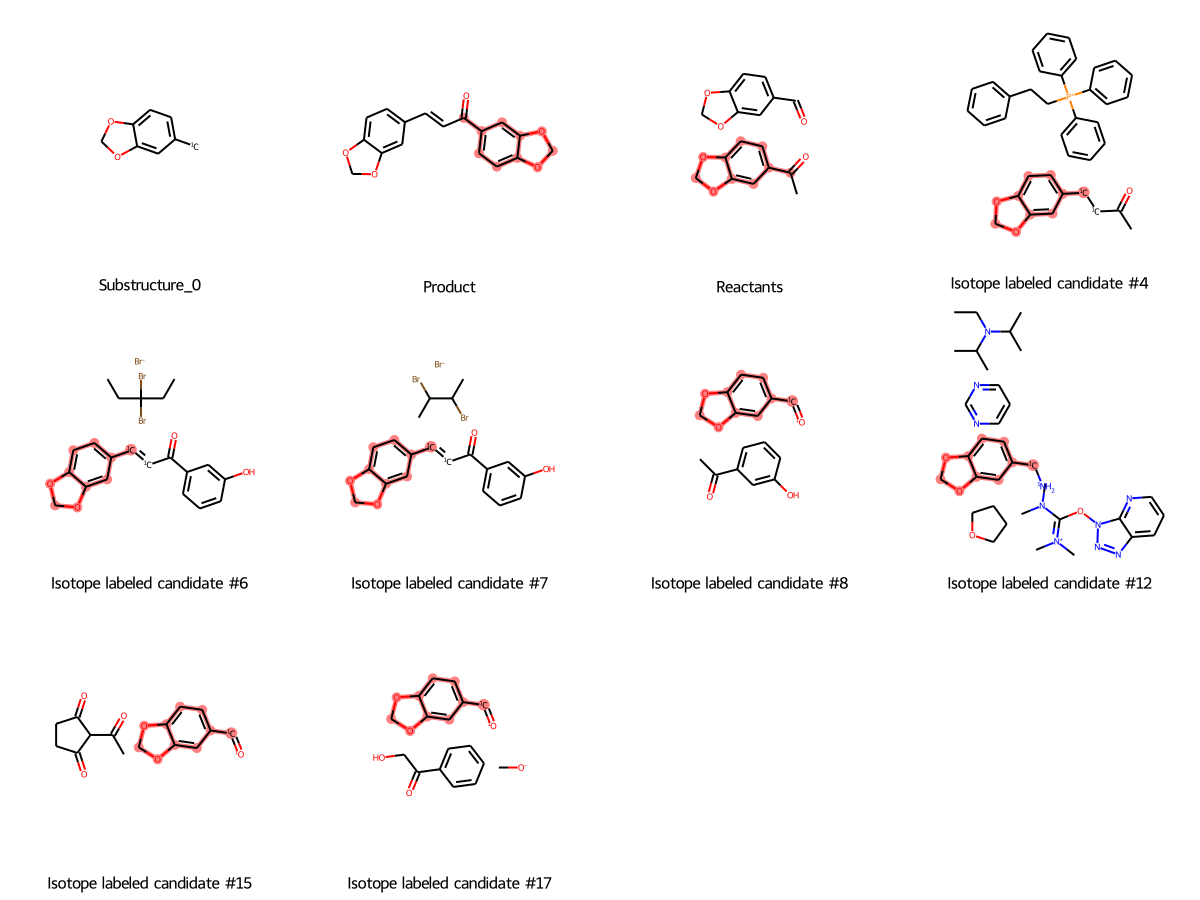

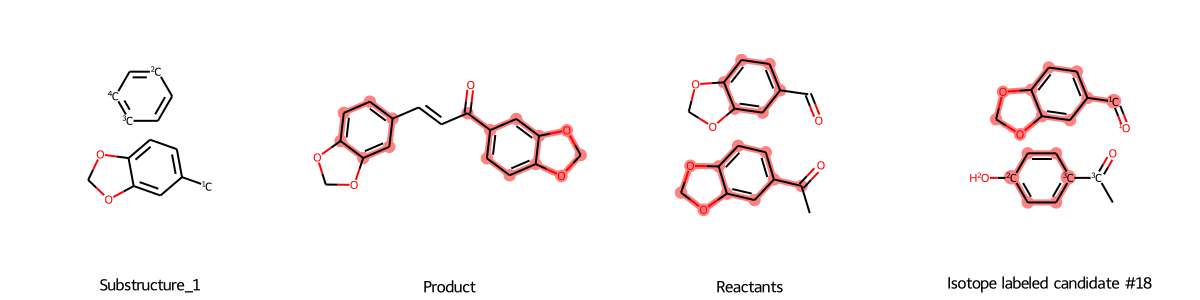

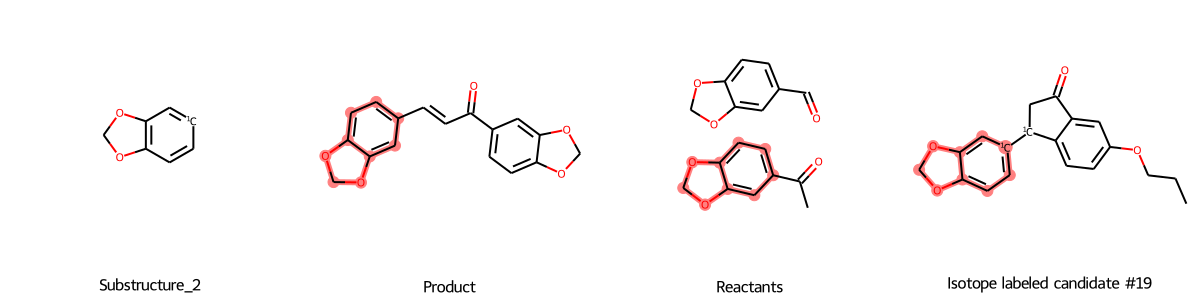

In [10]:
# do substructure extraction from all retrieved candidates
extraction_results = extract_all(input_product_smiles, candidates, all_reaction_t2s, min_count=5)

# view extraction results
# NOTE1: some isotope numbers in substructure are not shown in the labeled candidate reactants,
# because the product molecules of those candidates have none-substrcucture neighbour atoms, 
# which are not shown here.
# NOTE2: some substructures differ only in the isotope numbers, we consider them as different
# substructures.
view_sub_extractions(input_product_smiles, golden_reactants_smiles, candidates, extraction_results)
   

In [11]:
# prepare input for substructure-level sequence to sequence model inference
# subs_for_merge will be used to merge substructure with fragments
input_smiles, subs_for_merge = prepaire_sub_seq2seq_input(extraction_results)

# save the input 
save_input_for_subseq2seq(input_smiles)

# view random 5 samples
print('\n'.join(random.sample(input_smiles, 5)))

[1CH3] c 1 c c c 2 c ( c 1 ) O C O 2 | [1CH3] C ( = O ) c 1 c c c 2 c ( c 1 ) O C O 2
O 1 c 2 c c c ( [1CH3] ) c c 2 O C 1 | c 1 ( c c 2 c ( c c 1 ) O C O 2 ) C ( = O ) [1CH3]
c 1 2 c ( c c ( c c 2 ) [1CH3] ) O C O 1 | O 1 C O c 2 c 1 c c c ( c 2 ) C ( = O ) [1CH3]
[1CH3] c 1 c c c 2 c ( c 1 ) O C O 2 | [1CH3] C ( = O ) c 1 c c c 2 c ( c 1 ) O C O 2
c 1 c [2cH] c [4cH] [3cH] 1 . c 1 2 O C O c 2 c c ( [1CH3] ) c c 1 | [3OH] C [4OH] . [1CH3] [2CH] = O


In [12]:
# view the script for inference
# Note: n_best is set to 10
! cat demo_data/subseq2seq.sh

print('\n\n\n############### Run Inference ###############\n\n\n')

! bash demo_data/subseq2seq.sh

#!/bin/bash

# current directory
CURRENT_DIR=$PWD
# script directory
SCRIPT_DIR=$(cd "$(dirname "${BASH_SOURCE[0]}")" &> /dev/null && pwd)
# change to script directory
cd $SCRIPT_DIR
# uncomment -gpu 1 if you have GPUs
python ../MolecularTransformer/translate.py \
            -model subseq2seq.pt \
            -src test_input_seq2seq.txt \
            -output predict_output.txt \
            -batch_size 10 -replace_unk -max_length 200 -fast -n_best 10 -beam_size 10  -gpu 1
cd $CURRENT_DIR


############### Run Inference ###############



PRED AVG SCORE: -0.0006, PRED PPL: 1.0006


In [13]:
# load model output, a list of tuple (rank, predicted_fragments)
rank_pred_frag_list = load_sub_seq2seq_output()
rank_pred_frag_list[:5]

[(0, 'CC(=O)c1ccc2c(c1)OCO2.[1OH2]'),
 (1, '[1CH3]C(=O)c1ccc2c(c1)OCO2'),
 (2, 'C[1CH]=O.O=Cc1ccc2c(c1)OCO2'),
 (3, 'CI.[1CH3]C(=O)c1ccc2c(c1)OCO2'),
 (4, 'C[3CH]=O.[1OH2].c1ccc2c(c1)OCO2')]

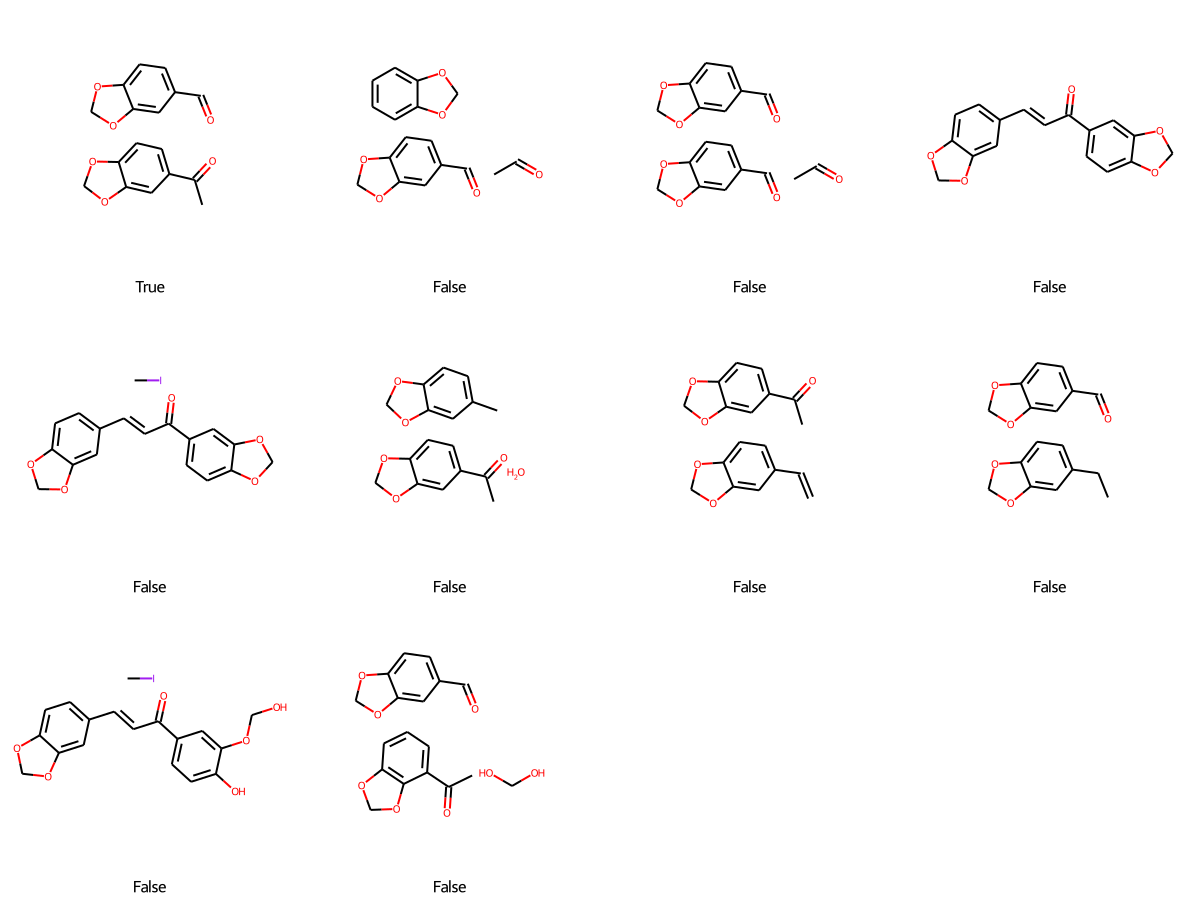

In [14]:
# merge predicted fragments with substructures
# predict2sub_rank is a dictionary
#       key: SMILES of merged reactants
#       value: a list of tuple (SMILES of substructure, PLACEHOLDER, rank) 
# we will extract features from value for reranking. 
# all_predictions is a list of tuple (SMILES of merged reactants, flag) and flag = [True, False]
# there might have duplicate entries in all_predictions, because different substructures might have same prediction.
pred2sub_rank, all_predictions = merge_predicted_frag_with_substructures(rank_pred_frag_list, subs_for_merge, golden_reactants_smiles)

# view most frequent entries in all_predictions
predicted_smi2label_list = [ele[0] for ele in Counter(all_predictions).most_common(10)]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in predicted_smi2label_list], legends=[str(ele[1]) for ele in predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))

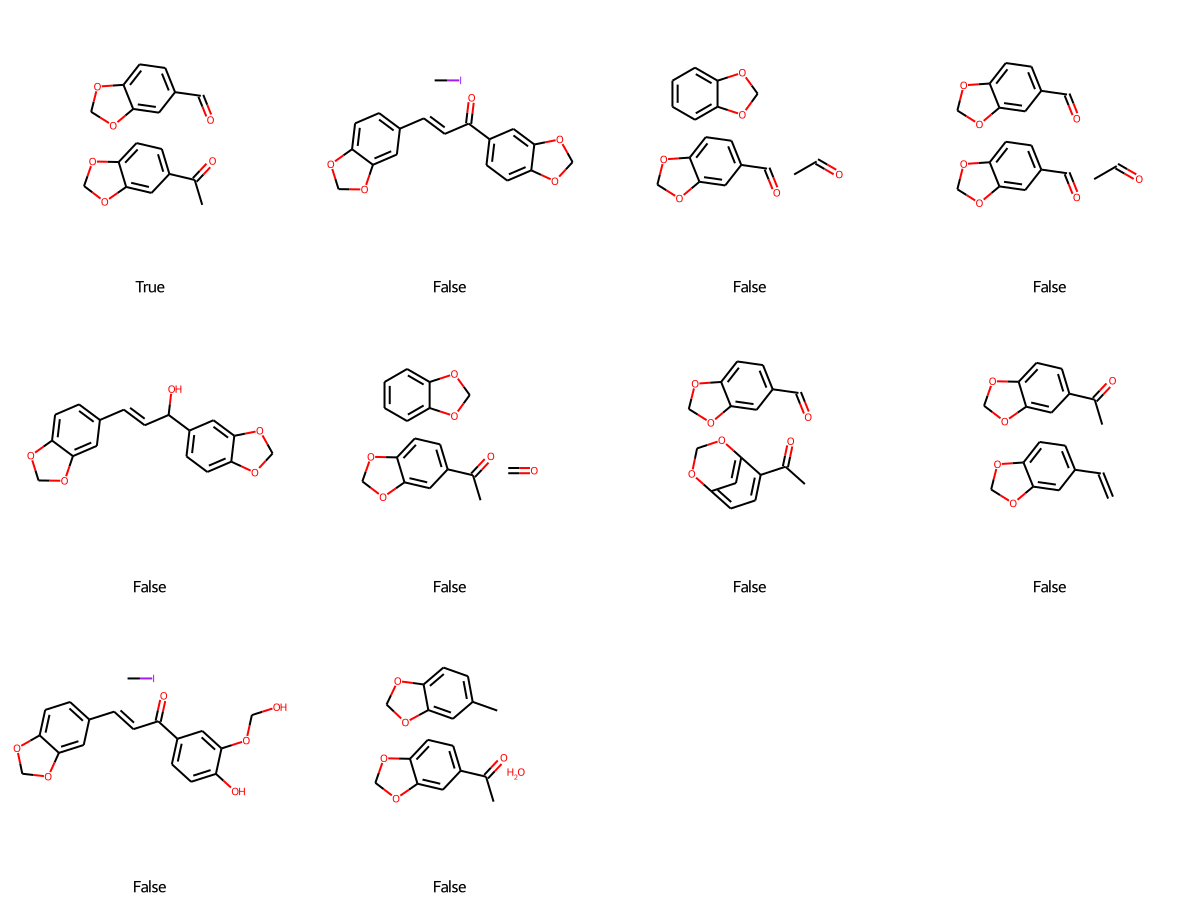

In [15]:
# rerank
pred_smi2score = rerank_candidates(input_product_smiles, pred2sub_rank, all_predictions)
d = sorted(pred_smi2score.items(), key=operator.itemgetter(1),reverse=True)
reranked_predicted_smi2label_list = [ele[0] for ele in d[:10]]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in reranked_predicted_smi2label_list], legends=[str(ele[1]) for ele in reranked_predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))